In [ ]:
# LSTM + multiple model

In [1]:
conda install tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [24]:
data = pd.read_csv('../data/cpu_memory_usage_v1.csv', header=0)
# 231635
# 781952

In [25]:
data['time'] = pd.to_datetime(data['time'], unit='ns')
data1 = data.loc[data.pod_name == 'drive-az2-prd-69cbb999bc-2wdsh']
data2 = data.loc[data.pod_name == 'drive-az2-prd-69cbb999bc-chm2j']
date_time = pd.to_datetime(data['time'], format='%Y-%M-%D %H:%M:%S')
data2

,index,name,tags,time,pod_name,namespace,cpu_usage_nanocores,memory_working_set_bytes
4,5,kubernetes_pod_container,NaN,2023-03-10 23:13:20,drive-az2-prd-69cbb999bc-chm2j,drive,93409866,1294434304
20,21,kubernetes_pod_container,NaN,2023-03-10 23:13:20,drive-az2-prd-69cbb999bc-chm2j,drive,60763677,1296531456
35,36,kubernetes_pod_container,NaN,2023-03-10 23:13:20,drive-az2-prd-69cbb999bc-chm2j,drive,76771766,1296531456
37,38,kubernetes_pod_container,NaN,2023-03-10 23:13:20,drive-az2-prd-69cbb999bc-chm2j,drive,101022354,1296531456
53,54,kubernetes_pod_container,NaN,2023-03-10 23:13:20,drive-az2-prd-69cbb999bc-chm2j,drive,76894003,1296531456
...,...,...,...,...,...,...,...,...
231578,231579,kubernetes_pod_container,NaN,2023-03-17 16:20:00,drive-az2-prd-69cbb999bc-chm2j,drive,15046036,1320103936
231591,231592,kubernetes_pod_container,NaN,2023-03-17 16:20:00,drive-az2-prd-69cbb999bc-chm2j,drive,25133138,1320128512
231607,231608,kubernetes_pod_container,NaN,2023-03-17 16:20:00,drive-az2-prd-69cbb999bc-chm2j,drive,18425930,1320128512
231622,231623,kubernetes_pod_container,NaN,2023-03-17 16:20:00,drive-az2-prd-69cbb999bc-chm2j,drive,15635455,1320128512


In [107]:
def create_sequences(temp, seq_length):
    xs = []
    ys = []
    for i in range(len(temp)-seq_length):
        x = temp.iloc[i:(i+seq_length)]
        y = temp.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [118]:
data1 = data1.loc[:,['memory_working_set_bytes']]
data2 = data2.loc[:,['memory_working_set_bytes']]

In [154]:
data1.shape, data2.shape
data2 = data2[:19299]

In [155]:
seq_length = 24
X1, Y1= create_sequences(data1, seq_length)
X2, Y2= create_sequences(data2, seq_length)


In [156]:
data1.shape, data2.shape, X1.shape, X2.shape

((19299, 1), (19299, 1), (19275, 24, 1), (19275, 24, 1))

In [157]:
train_size = 13000
offset_size = 500
X1_train, y1_train = X1[:train_size], Y1[:train_size]
X1_val, y1_val = X1[train_size:train_size+offset_size], Y1[train_size:train_size+offset_size]
X1_test, y1_test = X1[train_size+offset_size:], Y1[train_size+offset_size:]

X2_train, y2_train = X2[:train_size], Y2[:train_size]
X2_val, y2_val = X2[train_size:train_size+offset_size], Y2[train_size:train_size+offset_size]
X2_test, y2_test = X2[train_size+offset_size:], Y2[train_size+offset_size:]

In [158]:
X1_test.shape, X2_test.shape

((5775, 24, 1), (5775, 24, 1))

In [159]:

MIN1 = X1_train.min()
MAX1 = X1_train.max()


MIN2 = X2_train.min()
MAX2 = X2_train.max()

In [160]:

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)


In [161]:

#MinMax 스케일링
X1_train = MinMaxScale(X1_train, MIN1, MAX1)
y1_train = MinMaxScale(y1_train, MIN1, MAX1)
X1_val = MinMaxScale(X1_val, MIN1, MAX1)
y1_val = MinMaxScale(y1_val, MIN1, MAX1)
X1_test = MinMaxScale(X1_test, MIN1, MAX1)
y1_test = MinMaxScale(y1_test, MIN1, MAX1)


X2_train = MinMaxScale(X2_train, MIN2, MAX2)
y2_train = MinMaxScale(y2_train, MIN2, MAX2)
X2_val = MinMaxScale(X2_val, MIN2, MAX2)
y2_val = MinMaxScale(y2_val, MIN2, MAX2)
X2_test = MinMaxScale(X2_test, MIN2, MAX2)
y2_test = MinMaxScale(y2_test, MIN2, MAX2)

In [162]:
y1_train = pd.DataFrame(y1_train, columns = ['memory_working_set_bytes'])
y1_val = pd.DataFrame(y1_val, columns = ['memory_working_set_bytes'])
y1_test = pd.DataFrame(y1_test, columns = ['memory_working_set_bytes'])


y2_train = pd.DataFrame(y2_train, columns = ['memory_working_set_bytes'])
y2_val = pd.DataFrame(y2_val, columns = ['memory_working_set_bytes'])
y2_test = pd.DataFrame(y2_test, columns = ['memory_working_set_bytes'])


In [163]:

X1_train_tensors_f = tf.reshape(X1_train,   (X1_train.shape[0],1, X1_train.shape[1]))
X1_test_tensors_f = tf.reshape(X1_test,  ( X1_test.shape[0], 1, X1_test.shape[1])) 

print("Training Shape", X1_train_tensors_f.shape, y1_train.shape)
print("Testing Shape", X1_test_tensors_f.shape, y1_test.shape) 


X2_train_tensors_f = tf.reshape(X2_train,   (X2_train.shape[0], 1, X2_train.shape[1]))
X2_test_tensors_f = tf.reshape(X2_test,  ( X2_test.shape[0], 1, X2_test.shape[1])) 

print("Training Shape", X2_train_tensors_f.shape, y2_train.shape)
print("Testing Shape", X2_test_tensors_f.shape, y2_test.shape) 

Training Shape (13000, 1, 24) (13000, 1)
Testing Shape (5775, 1, 24) (5775, 1)
Training Shape (13000, 1, 24) (13000, 1)
Testing Shape (5775, 1, 24) (5775, 1)


In [138]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=y1_train, test_df=y1_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [139]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [140]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [141]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example

In [40]:
single_step_window = WindowGenerator(
    input_width=96, label_width=96, shift=1,
    label_columns=['memory_working_set_bytes'])
single_step_window

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Label column name(s): ['memory_working_set_bytes']

In [41]:
example_window = tf.stack([np.array(y1_train[:single_step_window.total_window_size]),
                           np.array(y1_train[1000:1000+single_step_window.total_window_size]),
                           np.array(y1_train[2000:2000+single_step_window.total_window_size])])

example_inputs, example_labels = single_step_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 97, 1)
Inputs shape: (3, 96, 1)
Labels shape: (3, 96, 1)


In [42]:

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 

In [43]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [45]:
column_indices = {name: i for i, name in enumerate(data1.columns)}
baseline = Baseline(label_index=column_indices['memory_working_set_bytes'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

performance = {}
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
performance

{'Baseline': [0.0028738456312566996, 0.012517966330051422]}

In [46]:
inputs, labels = single_step_window.example
train_predict = baseline(inputs)
train_predict.shape

TensorShape([32, 96, 1])

In [47]:
plot_col_index = single_step_window.column_indices['memory_working_set_bytes']
plot_col_index

0

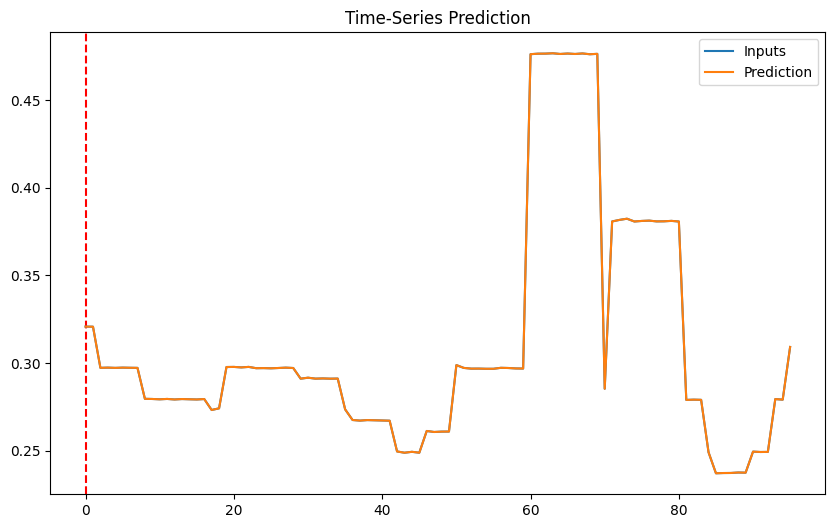

In [49]:

plt.figure(figsize=(10,6)) 
plt.axvline(c='r', linestyle='--') 
plt.plot(single_step_window.input_indices, inputs[0, :, plot_col_index],
            label='Inputs')
plt.plot(single_step_window.input_indices, train_predict[0, :, single_step_window.label_columns_indices.get('memory_working_set_bytes', None)],
            label='Prediction')
# plt.scatter(single_step_window.label_indices, train_predict[0, :, single_step_window.label_columns_indices.get('memory_working_set_bytes', None)],
#             marker='X', edgecolors='k', label='Predictions',
#             c='#ff7f0e', s=64)

plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [181]:

inputA = tf.keras.layers.Input(shape=(1, 24, ))
inputB = tf.keras.layers.Input(shape=(1, 24, ))

a = tf.keras.layers.LSTM(32, return_sequences=False,activation="relu")(inputA)
a = tf.keras.layers.Dense(units=32, activation='relu')(a)
a = tf.keras.layers.Dense(units=1)(a)
a = tf.keras.models.Model(inputs=inputA, outputs=a)


b = tf.keras.layers.LSTM(32, return_sequences=False,activation="relu")(inputB)
b = tf.keras.layers.Dense(units=32, activation='relu')(b)
b = tf.keras.layers.Dense(units=1)(b)
b = tf.keras.models.Model(inputs=inputB, outputs=b)


# combined = tf.keras.layers.concatenate([a.output, b.output])


# result = tf.keras.layers.Dense(2, activation="relu")(combined)
# result = tf.keras.layers.Dense(1, activation="linear")(result)

model = tf.keras.models.Model(inputs=[a.input, b.input], outputs=[a.output, b.output])

In [182]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint

MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')

model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = model.fit(x=[X1_train_tensors_f, X2_train_tensors_f], y=[y1_train, y2_train], epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/1000
372/407 [==========================>...] - ETA: 0s - loss: 0.0081 - dense_49_loss: 0.0032 - dense_51_loss: 0.0049 - dense_49_mean_absolute_error: 0.0328 - dense_51_mean_absolute_error: 0.0410
Epoch 1: loss improved from inf to 0.00763, saving model to model/tmp_checkpoint_v3.h5
407/407 [==============================] - 1s 1ms/step - loss: 0.0076 - dense_49_loss: 0.0031 - dense_51_loss: 0.0046 - dense_49_mean_absolute_error: 0.0317 - dense_51_mean_absolute_error: 0.0394
Epoch 2/1000
359/407 [=========================>....] - ETA: 0s - loss: 0.0022 - dense_49_loss: 9.5934e-04 - dense_51_loss: 0.0013 - dense_49_mean_absolute_error: 0.0164 - dense_51_mean_absolute_error: 0.0191
Epoch 2: loss improved from 0.00763 to 0.00220, saving model to model/tmp_checkpoint_v3.h5
407/407 [==============================] - 0s 883us/step - loss: 0.0022 - dense_49_loss: 9.7137e-04 - dense_51_loss: 0.0012 - dense_49_mean_absolute_error: 0.0164 - dense_51_mean_absolute_error: 0.0187
Epoch 3/10

In [183]:
performance['lstm_model'] = model.evaluate(x=[X1_train_tensors_f, X2_train_tensors_f], y=[y1_train, y2_train], verbose=0)

In [184]:
train_predict = model.predict([X1_test_tensors_f, X2_test_tensors_f])

181/181 [==============================] - 0s 443us/step


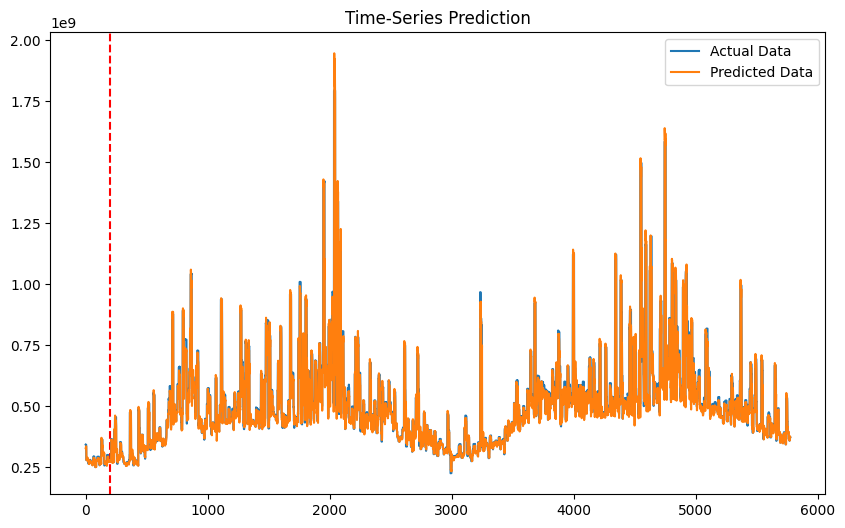

In [192]:

predicted = train_predict[1] * MAX2
label_y = y2_test * MAX2
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [193]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')
# performance

Baseline    : 0.0125
lstm_model  : 0.0006
